<a href="https://colab.research.google.com/github/AndrewFatula/Simple-CNNs/blob/master/Emnist_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import time
import torch
import torchvision
import torch.utils.data
import numpy as np
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gzip
import time




In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


downloaded = drive.CreateFile({'id':'13bnLTUp2mDUb5vWGfF1xL5KjCeD8dZV8'}) # replace the id with id of file you want to access
downloaded.GetContentFile('emnist-byclass-train-images-idx3-ubyte.gz') 
downloaded = drive.CreateFile({'id':'1RMTqdOjkO6KmsMArQyWw5fnNztqKHtpa'}) # replace the id with id of file you want to access
downloaded.GetContentFile('emnist-byclass-train-labels-idx1-ubyte.gz') 
downloaded = drive.CreateFile({'id':'1xZ-fxPBLfdjjeOgZx_v2MR-Mp1um4AQB'}) # replace the id with id of file you want to access
downloaded.GetContentFile('emnist-byclass-test-images-idx3-ubyte.gz')
downloaded = drive.CreateFile({'id':'106i5WLw_5dqqT-78AX1wYLxpPdJpZYNn'}) # replace the id with id of file you want to access
downloaded.GetContentFile('emnist-byclass-test-labels-idx1-ubyte.gz')


train_images_file = "emnist-byclass-train-images-idx3-ubyte.gz"
train_labels_file = "emnist-byclass-train-labels-idx1-ubyte.gz"
test_images_file = "emnist-byclass-test-images-idx3-ubyte.gz"
test_labels_file = "emnist-byclass-test-labels-idx1-ubyte.gz"

f_images_train = gzip.open(train_images_file,'r')
f_labels_train = gzip.open(train_labels_file, 'r')
f_images_test = gzip.open(test_images_file,'r')
f_labels_test = gzip.open(test_labels_file, 'r')

f_images_train.read(16)
f_labels_train.read(8)
f_images_test.read(16)
f_labels_test.read(8)

buf_train_images = f_images_train.read()
buf_train_labels = f_labels_train.read()
buf_test_images = f_images_test.read()
buf_test_labels = f_labels_test.read()

len_train = int(len(buf_train_images)/28/28)
len_test = int(len(buf_test_images)/28/28)


print(len_train)

train_images = np.swapaxes(np.frombuffer(buf_train_images, dtype=np.uint8).astype(np.float32).reshape(len_train, 1, 28, 28), 2, 3)
train_labels = np.frombuffer(buf_train_labels, dtype=np.uint8).astype(np.float32)
test_images = np.swapaxes(np.frombuffer(buf_test_images, dtype=np.uint8).astype(np.float32).reshape(len_test, 1, 28, 28), 2, 3)
test_labels = np.frombuffer(buf_test_labels, dtype=np.uint8).astype(np.float32)

if len_train == len(train_labels):
  print("all is ok")
else:
  print("all is not ok")  

print(len(train_labels))





Code above for downloading and prepocessing dataset

In [0]:
classes_lengths = []
classes_indices = []
classes_lengths_test = []
classes_indices_test = []
unique_classes = np.unique(train_labels)a



for char in unique_classes:
  classes_lengths.append(len(train_labels[train_labels == char]))
  classes_indices.append(np.array(list(np.where(train_labels==char)[0])))
  classes_lengths_test.append(len(test_labels[test_labels == char]))
  classes_indices_test.append(np.array(list(np.where(test_labels==char)[0])))

print(np.mean(classes_lengths))

for i in range(len(classes_lengths)):
  if classes_lengths[i] > 5000:
    classes_indices[i] = (classes_indices[i][np.random.choice(classes_lengths[i], 10000)])
  if classes_lengths[i] > 1000:
    classes_indices_test[i] = (classes_indices_test[i][np.random.choice(classes_lengths_test[i], 1000)])  
    



balanced_indices = []
for i in range(len(classes_lengths)-1):
  balanced_indices = balanced_indices + classes_indices[i+1].tolist()

balanced_test_indices = []
for i in range(len(classes_lengths)-1):
  balanced_test_indices = balanced_test_indices + classes_indices_test[i+1].tolist()

np.random.shuffle(balanced_indices)
np.random.shuffle(balanced_test_indices)



train_labels = train_labels[balanced_indices]
train_images = train_images[balanced_indices, :, :, :]
test_labels = test_labels[balanced_test_indices]
test_images = test_images[balanced_test_indices, :, :, :]

indices_without_lower_train = list(np.where(train_labels < 36)[0])
indices_without_lower_test = list(np.where(test_labels < 36)[0])

train_labels_filtered = train_labels[indices_without_lower_train]-1
test_labels_filtered = test_labels[indices_without_lower_test]-1
train_images_filtered = train_images[indices_without_lower_train, :, :, :]
test_images_filtered = test_images[indices_without_lower_test, :, :, :]
unique_classes = np.unique(train_labels_filtered)
print(unique_classes)





11256.967741935483
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]


In [0]:
device = torch.device("cuda")
learning_rate = 0.00005
n_of_epochs = 1000
num_classes = len(unique_classes)
n_of_filters = 32
fcl_1 = 2048
fcl_2 = 512



Defining all constant variables

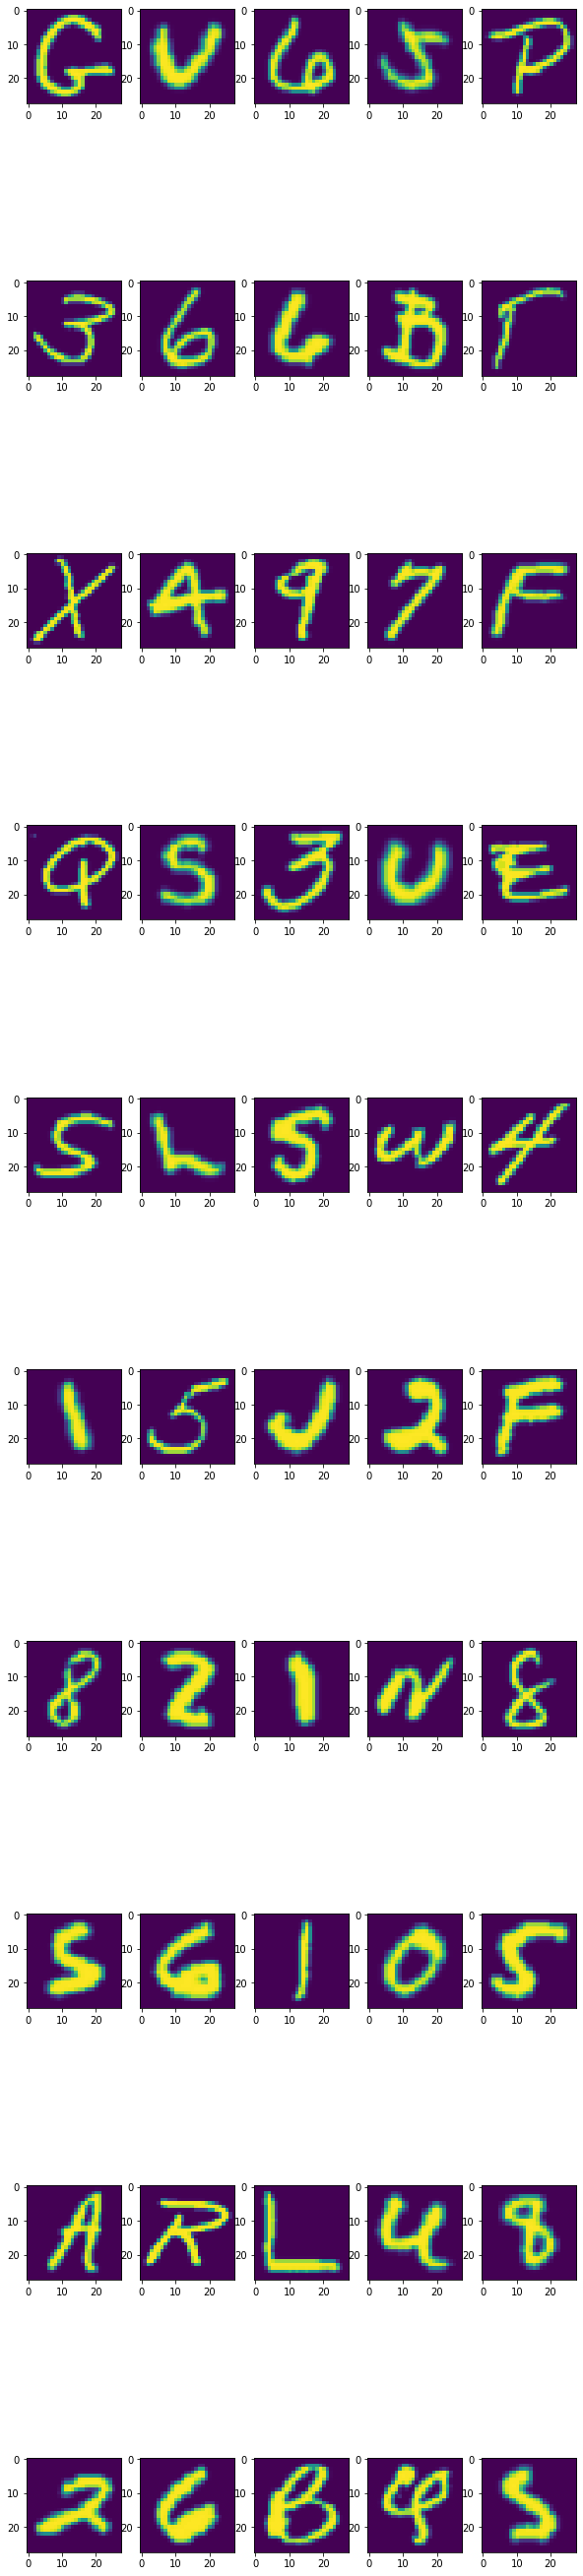

[[15. 29.  5.  4. 24.]
 [ 2.  5.  5. 10. 28.]
 [32.  3.  8.  6. 14.]
 [25. 27.  2. 29. 13.]
 [ 4. 20. 27. 31.  3.]
 [17.  4. 18.  1. 14.]
 [ 7.  1. 17. 22.  7.]
 [27.  5.  0. 23.  4.]
 [ 9. 26. 20. 29.  7.]
 [ 1.  5. 10. 25. 27.]]


In [0]:

plt.figure(figsize = (10,50))

for i in range(50):
  plt.subplot(10,5,1+i)
  plt.imshow(train_images_filtered[i, 0, :, :])
  

plt.show()
plt.close() 

print(train_labels_filtered[0:50].reshape(10,5))



In [0]:
class Emnist_Net(nn.Module):
	def __init__(self):
		super(Emnist_Net, self).__init__()
		self.conv1 = nn.Sequential(
				nn.Conv2d(in_channels=1, out_channels=n_of_filters,
						  kernel_size=(5,5), stride=1, padding=0),
				nn.ReLU(),
				nn.Dropout2d(p=0.3))
		self.conv_pipe1 = nn.Sequential(
				nn.Conv2d(in_channels=int(n_of_filters), out_channels=int(n_of_filters),
						  kernel_size=(1,1), stride=1, padding=0),
				nn.ReLU(),
				nn.Dropout2d(p=0.4), 
				nn.Conv2d(in_channels=int(n_of_filters), out_channels=n_of_filters,
						  kernel_size=(3,3), stride=1, padding=0),
				nn.ReLU(),
				nn.Conv2d(in_channels=int(n_of_filters), out_channels=int(n_of_filters*4),
						  kernel_size=(1,1), stride=1, padding=0)
							)
		self.pool = nn.MaxPool2d(kernel_size = (2,2))
		self.conv_pipe2 = nn.Sequential(
				nn.Conv2d(in_channels=n_of_filters*4, out_channels=n_of_filters*4,
						  kernel_size=(1,1), stride=1, padding=0),
				nn.ReLU(),
				nn.Conv2d(in_channels=n_of_filters*4, out_channels=n_of_filters*4,
						  kernel_size=(3,3), stride=1, padding=0),
				nn.ReLU(),
				nn.Dropout2d(p=0.4), 
				nn.Conv2d(in_channels=n_of_filters*4, out_channels=n_of_filters*16,
						  kernel_size=(1,1), stride=1, padding=0))
	
		self.pool2 = nn.MaxPool2d(kernel_size = (3,3))
		self.dropout = nn.Dropout2d(p=0.3)
		self.relu = nn.ReLU()


	
		self.shortcut1 = nn.Conv2d(in_channels = n_of_filters, out_channels = n_of_filters*4, kernel_size = (3,3))
		self.shortcut2 = nn.Conv2d(in_channels = n_of_filters*4, out_channels = n_of_filters*16, kernel_size = (3,3))

		self.dense_pipe =  nn.Sequential(
				nn.Linear(n_of_filters*3*3*16, fcl_1),
				nn.Sigmoid(),
				nn.Dropout2d(p=0.2),
				nn.Linear(fcl_1, fcl_2),
				nn.Sigmoid(),
				nn.Dropout2d(p=0.2),
				nn.Linear(fcl_2, num_classes),
				nn.Softmax(dim = 1)
			)
	
		self.dense1_pipe = nn.Sequential(
				nn.Linear(784, fcl_1),
				nn.Sigmoid(),
				nn.Dropout2d(p=0.4),
				nn.Linear(fcl_1, num_classes),
				nn.Softmax(dim = 1)
		)

	
		
	def forward(self, x):
		
		convolved = self.conv1(x)
		short1 = self.shortcut1(convolved)
		conv2 = self.dropout(self.relu(self.conv_pipe1(convolved) + short1))
		conv2 = self.pool(conv2)
		short2 = self.shortcut2(conv2)
		conv3 = self.dropout(self.relu(self.conv_pipe2(conv2) + short2))
		conv3 = self.pool2(conv3)
		conv3 = conv3.view(-1, n_of_filters*3*3*16)
		
		#conv3 = x.view(-1, 784)
		return self.dense_pipe(conv3)
	


def get_accuracy(model, x, y, batch_size = 256):
	batched_x , batched_y = get_batches(x, y, batch_size = batch_size)
	batched_test = list(zip(batched_x, batched_y))
 
	total_sum = 0
	for x_batch, y_batch in batched_test:
		x_batch = torch.FloatTensor(x_batch).to(device)
		output = model(x_batch).detach().to("cpu").numpy()
		numbers = np.argmax(output, axis = 1)
		indices = np.where(numbers == y_batch, 1, 0)
		total_sum += sum(indices) if len(list(indices)) > 0 else 0
	return total_sum/len(y)
 


def get_batches(x, y, batch_size = 256):

	zipped = list(zip(x, y))
	np.random.shuffle(zipped)
	data = list(zip(*zipped))
	x = data[0]
	y = data[1]

	n_of_instances = len(y)
	n_of_batches = int(n_of_instances/batch_size)
	
	batched_x = []
	batched_y = []

	for i in range(n_of_batches):
		batch_x = []
		batch_y = []
		for j in range(batch_size):
			batch_x.append(x[i*batch_size + j])
			batch_y.append(y[i*batch_size + j])
		batched_x.append(batch_x)
		batched_y.append(batch_y)
	
	return np.array(batched_x), np.array(batched_y)

Code above is code for Pytorch model.

In [0]:
batched_x, batched_y = get_batches(train_images_filtered, train_labels_filtered)

In [0]:
from google.colab import files
import copy
state_dict = {}

best_accuracy = 0
start = time.localtime(time.time())
net = Emnist_Net().to(device)
loss_objective = nn.CrossEntropyLoss()
optimizer =  optim.Adam(params=net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

k = 0
for epoch in range(n_of_epochs):
  epoch_start = time.localtime(time.time())
  batched_x, batched_y = get_batches(train_images_filtered, train_labels_filtered, batch_size = 256)
  if (epoch+1)%50 == 0:
    k+=1
    optimizer = optim.Adam(params=net.parameters(), lr=learning_rate*0.8**k, betas=(0.9 - 0.0002*epoch, 0.999))

  for images_batch, labels_batch in list(zip(batched_x, batched_y)):
    optimizer.zero_grad()
    images_batch = torch.FloatTensor(images_batch).to(device)
    labels_batch = torch.LongTensor(labels_batch).to(device)
    model_output = net.forward(images_batch)
		
    loss = loss_objective(model_output, labels_batch)
    loss.backward()
    optimizer.step()

    
  accuracy = get_accuracy(net, test_images_filtered, test_labels_filtered)
  epoch_end = time.localtime(time.time())
  epoch_start_in_sec = epoch_start[3]*3600 + epoch_start[4]*60 + epoch_start[5]
  epoch_end_in_sec = epoch_end[3]*3600 + epoch_end[4]*60 + epoch_end[5]
  if accuracy > best_accuracy:
    best_accuracy = accuracy
    state_dict = copy.deepcopy(net.state_dict())
  print("Epoch: " + str(epoch)+ " Accuracy: " + str(accuracy) + "  and time: " + str(epoch_end_in_sec-epoch_start_in_sec))  

print(best_accuracy)



print("\n")

end = time.localtime(time.time())
start_in_sec = start[3]*3600 + start[4]*60 + start[5]
end_in_sec = end[3]*3600 + end[4]*60 + end[5]


all_time_min = int((end_in_sec-start_in_sec)/60)
all_time_sec = (end_in_sec-start_in_sec)%60
if all_time_min < 10:
	if all_time_sec < 10:
		print('0%s:0%s' % (all_time_min, all_time_sec ))
	else:
		print('0%s:%s' % (all_time_min, all_time_sec ))	
else:
	if all_time_sec < 10:
		print('%s:0%s' % (all_time_min, all_time_sec ))
	else:
		print('%s:%s' % (all_time_min, all_time_sec ))	




Epoch: 0 Accuracy: 0.35337142857142856  and time: 78
Epoch: 1 Accuracy: 0.41454285714285716  and time: 77
Epoch: 2 Accuracy: 0.5221142857142858  and time: 77
Epoch: 3 Accuracy: 0.5546285714285715  and time: 78
Epoch: 4 Accuracy: 0.5572857142857143  and time: 77
Epoch: 5 Accuracy: 0.5579428571428572  and time: 77
Epoch: 6 Accuracy: 0.5584857142857143  and time: 77
Epoch: 7 Accuracy: 0.6089714285714286  and time: 77
Epoch: 8 Accuracy: 0.6859428571428572  and time: 78
Epoch: 9 Accuracy: 0.7142  and time: 77
Epoch: 10 Accuracy: 0.7165428571428571  and time: 77
Epoch: 11 Accuracy: 0.7179142857142857  and time: 77
Epoch: 12 Accuracy: 0.7671428571428571  and time: 77
Epoch: 13 Accuracy: 0.7944285714285715  and time: 77
Epoch: 14 Accuracy: 0.8057714285714286  and time: 77
Epoch: 15 Accuracy: 0.8364857142857143  and time: 77
Epoch: 16 Accuracy: 0.8375428571428571  and time: 77
Epoch: 17 Accuracy: 0.8391714285714286  and time: 77
Epoch: 18 Accuracy: 0.8402285714285714  and time: 77
Epoch: 19 Acc

In [0]:
file = 'dictionary2.pth'

torch.save(state_dict, file)

files.download('dictionary2.pth')
print("Downloaded")

Downloaded
